In [1]:
from sage.interfaces.gap import  get_gap_memory_pool_size, set_gap_memory_pool_size
set_gap_memory_pool_size(24364842180)

'''Graded characters in the regular block O_0.
Note: Notation is dominant: L(e) is finite dimensional, Delta(e) is projective, Delta(w0) = L(w0), ...'''


W = WeylGroup("F4", prefix="s")
[s1,s2,s3,s4] = W.simple_reflections()

##################################################################################

n = rank(W)
w0 = W.long_element()
e = W(1)


####### Kazhdan-Lusztig polynomials ##########################

# A faster implementation of KL-polynomials (using the optional package Coxeter 3) is given by this
# Fokko Ducloux’s Coxeter3 C++ library.

# Had to install it: I just typed "sage -i coxeter3" in the terminal.

# It seems that one can direcly coerce from WeylGroup to CoxeterGroup and vice versa.
# I will therefore use CoxeterGroup to calculate KL-polynomials, but for all other Bruhat business I will use WeylGroup.

R.<q> = LaurentPolynomialRing(QQ)

KL = KazhdanLusztigPolynomial(W,q)  # KL-polynomials implemented in standard Sage way
# http://doc.sagemath.org/html/en/reference/combinat/sage/combinat/kazhdan_lusztig.html


CoxeterPackage = CoxeterGroup(W, implementation="coxeter3")

def KLP(x,y):
    '''Returns the KL-polynomial, implemented in "Coxeter3" package by Fokko du Cloux.
    http://math.univ-lyon1.fr/~ducloux/coxeter/coxeter3/english/coxeter3_e.html'''
    
    if x not in W:
        x = convert_from_123(x)
    if y not in W:
        y = convert_from_123(y)
    
    return CoxeterPackage.kazhdan_lusztig_polynomial(CoxeterPackage(x), CoxeterPackage(y))
    # If "coxeter3" is not installed, remove the line 'CoxeterPackage = CoxeterGroup(W, implementation="coxeter3")'
    # and in this function return KL.P(x,y)
    #return KL.P(x,y)

#Point:
#    - standard Sage way: KL.P(x,y)
#    - faster way: KLP(x,y) 


R.<v> = LaurentPolynomialRing(QQ)
def KLPv(x,y):
    '''v-normalization: degree in the polynomial agrees with the graded degree in the Verma module.'''
    return KLP(x, y)(q=1/v^2) * v^(y.length()-x.length())


def mu(w,x):
    '''Returns the KL mu-function with arguments w,x.
    By Humphrey's BGG book p. 175 and p. 169, for w<x we have:
    mu(x,w) = mu(w0*w,w0*x),
    mu(w,x) = dim Exit^1 (L_w,L_x) = dim Exit^1(L_x,L_w) = dim Exit^1(Delta_x,L_w).'''

    if w not in W:
        w = convert_from_123(w)
    if x not in W:
        x = convert_from_123(x)
        
    if w.bruhat_le(x):
        poly_dict = KLP(w,x).dict()       
        j = (x.length()-w.length()-1)/2 
        if j not in poly_dict.keys():
            return 0
        return poly_dict[j]

    return 0


def dimExt(i,y,w):  
    '''Returns dimExt^i(Delta(y),L(w)).'''
    
    y = y*w0                               
    w = w*w0   
    poly_dict = KLP(y,w).dict()       
    j = (w.length()-y.length()-i)/2 
    if j not in poly_dict.keys():
        return 0
    return poly_dict[j]


def mult_Delta_L(y,w):
    '''Returns the Jordan-Holder multiplicity [Delta(y),L(w)] in O_0.
    This is quicker than the analogous operation on GradedChar classes because
    it does not calculate the full Delta.'''
      
    return KLP(y,w)(1)               


def mult_graded_Delta_L(w,k,x):
    '''Returns the graded Jordan-Holder multiplicity [Delta(w) shifted by k,L(x)].
    This is quicker than the analogous operation on GradedChar classes because
    it does not calculate the full Delta.''' 

    l_wx = x.length() - w.length()
    
    i = (l_wx-k)
    if i<0 or i%2!=0:
        return 0
    i = i/2
    
    KL_wx = KLP(w, x).dict()
    if i not in KL_wx.keys():
        return 0
    
    return KL_wx[i]


def earliest_occurence(x):
    '''Returns the smallest non-negative k such that L(x) occurs in Delta(e) at level k.
    To be used later in Lusztig's a function.'''
      
    for k in range(x.length()+1):
        
        if mult_graded_Delta_L(e,k,x) > 0:
            return k
    

##### Parabolic subgroups


def W_(Sigma):
    '''Parabolic subgroup W_Sigma as a list.'''
    
    return W.bruhat_interval(e,w0_(Sigma))


def minimal_rep(x,Sigma):
    '''The minimal representative of the class x*W_Sigma.'''
    
    return x.coset_representative(Sigma, side='right')


def w0_(Sigma):
    '''Returns the longest element of the parabolic subgroup defined by Sigma.
    Format of sigma: e.g. Sigma = [1,2,4] returns s4*s1*s2*s1.'''
    
    return (w0.coset_representative(Sigma, side='right')).inverse() * w0


def Maximal_elements_of_parabolics():
    '''Returns a list of the longest elements of all parabolic subgroups.'''
    
    return [w0_(Sigma) for Sigma in Subsets(range(1,rank(W)+1))]


        


    

def convert_to_123(w):
    '''Converts an element from W to the "123" string notation.
    Does not work with coefficients, as "convert_to_123_long".'''
    
    if w == W(1):
        return "e"
    
    return str(w).replace("s","").replace("*","")


def convert_from_123(string):
    '''Converts one element from W in the "123" string notation to the usual "s1*s2*s3" notation.'''
    
    if type(string)== Integer:
        string = str(string)
        
    if string == "e":
        return W(1)
    
    string = "*".join([char for char in string])
    
    for i in range(1,n+1):
        string = string.replace(str(i),"s%s"%i)
    
    return eval(string)


def DR(w):
    '''Returns the set of simple right descents of w.'''
    
    return {W.simple_reflections()[i] for i in w.descents()}


def DL(w):
    '''Returns the set of simple left   descents of w.'''
        
    return DR(w.inverse())


def AL(w):
    '''Returns the set of simple left ascends of w.'''
    
    DescLe = list(DL(w))
    AscLe = [s for s in W.simple_reflections() if s not in DescLe]
    return set(AscLe)


def AR(w):
    '''Returns the set of simple right ascends of w.'''
    
    DescRi = list(DR(w))
    AscRi = [s for s in W.simple_reflections() if s not in DescRi]
    return set(AscRi)




##############################################################
##############################################################
##############################################################




############### JOINS ###############              
                


def W_subposet(L):
    '''This is equivalent to W.bruhat_poset().subposet(),
    but without calculating the full W.bruhat_poset().'''
    
    def br_le(x,y):
        return x.bruhat_le(y)    
    return Poset((L,br_le))




def join(S):
    SS = [convert_from_123(a) for a in S if a not in W] + [a for a in S if a in W]
    
    U = set(W.bruhat_interval(SS[0],w0))
    for a in SS[1:]:
        U = U.intersection(set(W.bruhat_interval(a,w0)))
        
    minU = (W_subposet(list(U))).minimal_elements()
    
    if len(minU)==1:
        j = minU[0]
        return eval(convert_to_123(str(j)))
    else:
        return [eval(convert_to_123(x)) for x in minU]

    
    
    
def JM_(w):
    if w not in W:
        w = convert_from_123(w)
    result = W_subposet([x for x in join_irreducibles if x.bruhat_le(w) ]).maximal_elements()
    return [convert_from_123(convert_to_123(x)) for x in result]

def BM(w):
    if w not in W:
        w = convert_from_123(w)
    return W_subposet([x for x in bigrassmannians if x.bruhat_le(w) ]).maximal_elements()

def JM__(w):
    if w not in W:
        w = convert_from_123(w)
    DLw = DL(w)
    DRw = DR(w)
    result = []
    for x in JM_(w):
        x = convert_from_123(convert_to_123(x))
        if list(DL(x))[0] in DLw and list(DR(x))[0] in DRw:
            result.append(x)
    return result

def JM(w):
    if w not in W:
        w = convert_from_123(w)
    DLw = DL(w)
    DRw = DR(w)
    result = W_subposet([x for x in join_irreducibles if x.bruhat_le(w) and (list(DL(x))[0] in DLw) and (list(DR(x))[0] in DRw) ]).maximal_elements()
    return [convert_from_123(convert_to_123(x)) for x in result]    
    




print(DynkinDiagram(W))
    

    
    
############### JI POSETS ###############

    
def load_poset(which,i,j):
    '''which = "JI" or "BG" or "JI_socle_killing".'''
    data_folder = "Posets_data/" + CartanType(W)[0]+str(CartanType(W)[1]) + "/"
    P = load(data_folder + "%s_poset_%d%d"%(which,i,j))
    return P


def join_B(S,i,j):
    '''Here S is assumed to be a list of elements from JI[(i,j)].'''
    U = set(x for x in BG[(i,j)] if (S[0]).bruhat_le(x) )
    for a in S[1:]:
        U = U.intersection(set(x for x in BG[(i,j)] if a.bruhat_le(x) ))
        
    result = (W_subposet(list(U))).minimal_elements()
    if len(result)==1:
        return result[0]
    else:
#        raise ValueError
        return 0 # Join does not exist
    

def human(w):
    return convert_to_123(w)+"(%s)"%w.length()


def print_poset(P, **kwargs):
    size = kwargs.get('size', 10)
    red = kwargs.get('red', False)
    i = kwargs.get('i', None)
    j = kwargs.get('j', None)
    
    if red==True:
        color = {"red" : [(human(x[0]),human(x[1])) for x in P.cover_relations() if not is_socle_killing_pair(x[0],x[1],i,j)]}
    else:
        color = {}
    show(P.relabel(lambda x: human(x)).plot(figsize = size, vertex_shape="x", vertex_color="white",  cover_colors = color))
    
    
def r(i,j):
    return len((p[i,j]).exponents())-1

def is_socle_killing_pair(u,v,i,j):
    '''Assuming u<v, and both in the same JI(i,j).'''

    if u.bruhat_le( W.simple_reflections()[i] * v ) or u.bruhat_le(v* W.simple_reflections()[j]):
        return True
    return False

def br_le(w):
    return w.length()

O---O=>=O---O
1   2   3   4   
F4


In [2]:
############### JOINS ###############              
                
def W_subposet(L):
    '''This is equivalent to W.bruhat_poset().subposet(),
    but without calculating the full W.bruhat_poset().'''
    
    def br_le(x,y):
        return x.bruhat_le(y)    
    return Poset((L,br_le))




def join(S):
    SS = [convert_from_123(a) for a in S if a not in W] + [a for a in S if a in W]
    
    U = set(W.bruhat_interval(SS[0],w0))
    for a in SS[1:]:
        U = U.intersection(set(W.bruhat_interval(a,w0)))
        
    minU = (W_subposet(list(U))).minimal_elements()
    
#    if len(minU)==1:
#        j = minU[0]
#        return eval(convert_to_123(str(j)))
#    else:
    return [eval(convert_to_123(x)) for x in minU]

    
    
    
def JM_(w):
    if w not in W:
        w = convert_from_123(w)
    result = W_subposet([x for x in join_irreducibles if x.bruhat_le(w) ]).maximal_elements()
    return [convert_from_123(convert_to_123(x)) for x in result]

def BM(w):
    if w not in W:
        w = convert_from_123(w)
    return W_subposet([x for x in bigrassmannians if x.bruhat_le(w) ]).maximal_elements()

def JM__(w):
    if w not in W:
        w = convert_from_123(w)
    DLw = DL(w)
    DRw = DR(w)
    result = []
    for x in JM_(w):
        x = convert_from_123(convert_to_123(x))
        if list(DL(x))[0] in DLw and list(DR(x))[0] in DRw:
            result.append(x)
    return result

def JM(w):
    if w not in W:
        w = convert_from_123(w)
    DLw = DL(w)
    DRw = DR(w)
    result = W_subposet([x for x in join_irreducibles if x.bruhat_le(w) and (list(DL(x))[0] in DLw) and (list(DR(x))[0] in DRw) ]).maximal_elements()
    return [convert_from_123(convert_to_123(x)) for x in result] 

#penultimate = two_cell(s1*w0)



############### JI POSETS ###############

    
def load_poset(which,i,j):
    '''which = "JI" or "BG" or "JI_socle_killing".'''
    data_folder = "Posets_data/" + CartanType(W)[0]+str(CartanType(W)[1]) + "/"
    P = load(data_folder + "%s_poset_%d%d"%(which,i,j))
    return P


def join_B(S,i,j):
    '''Here S is assumed to be a list of elements from JI[(i,j)].'''
    U = set(x for x in BG[(i,j)] if (S[0]).bruhat_le(x) )
    for a in S[1:]:
        U = U.intersection(set(x for x in BG[(i,j)] if a.bruhat_le(x) ))
        
    result = (W_subposet(list(U))).minimal_elements()
    if len(result)==1:
        return result[0]
    else:
#        raise ValueError
        return 0 # Join does not exist
    

def human(w):
    return convert_to_123(w)+"(%s)"%w.length()


def print_poset(P, **kwargs):
    size = kwargs.get('size', 10)
    red = kwargs.get('red', False)
    i = kwargs.get('i', None)
    j = kwargs.get('j', None)
    
    if red==True:
        color = {"red" : [(human(x[0]),human(x[1])) for x in P.cover_relations() if not is_socle_killing_pair(x[0],x[1],i,j)]}
    else:
        color = {}
    #show(P.relabel(lambda x: human(x)).plot(figsize = size, vertex_shape="x", vertex_color="white",  cover_colors = color))
    return P.relabel(lambda x: human(x)).plot(figsize = size, 
                                               vertex_shape="x", 
                                               vertex_color="white",  
                                               cover_colors = color)
    
def r(i,j):
    return len((p[i,j]).exponents())-1

def is_socle_killing_pair(u,v,i,j):
    '''Assuming u<v, and both in the same JI(i,j).'''

    if u.bruhat_le( W.simple_reflections()[i] * v ) or u.bruhat_le(v* W.simple_reflections()[j]):
        return True
    return False

def br_le(w):
    return w.length()

In [3]:
######################## F4 ########################

#sum_J KL = 92

#bigrassmannians: 108

bigrassmannians = [s4, s4*s3, s4*s3*s2, s4*s3*s2*s1, s4*s3*s2*s3, s4*s3*s2*s3*s4, s4*s3*s2*s3*s1*s2, s4*s3*s2*s3*s1*s2*s3, s4*s3*s2*s3*s1*s2*s3*s4, s4*s3*s2*s3*s4*s1*s2*s3, s4*s3*s2*s3*s4*s1*s2*s3*s2, s4*s3*s2*s3*s4*s1*s2*s3*s2*s1, s4*s3*s2*s3*s1*s2*s3*s4*s3*s2*s3, s4*s3*s2*s3*s1*s2*s3*s4*s3*s2*s3*s1*s2, s4*s3*s2*s3*s1*s2*s3*s4*s3*s2*s3*s1*s2*s3, s4*s3*s2*s3*s1*s2*s3*s4*s3*s2*s3*s1*s2*s3*s4, s3, s3*s4, s3*s2, s3*s4*s2*s3, s3*s4*s2*s3*s2, s3*s4*s2*s3*s2*s1, s3*s2*s1, s3*s4*s2*s3*s1*s2, s3*s4*s2*s3*s1*s2*s3, s3*s4*s2*s3*s1*s2*s3*s4, s3*s4*s2*s3*s1*s2*s3*s1*s2, s3*s4*s2*s3*s1*s2*s3*s4*s1*s2*s3, s3*s4*s2*s3*s1*s2*s3*s4*s1*s2*s3*s2, s3*s4*s2*s3*s1*s2*s3*s4*s1*s2*s3*s2*s1, s3*s2*s3, s3*s2*s3*s4, s3*s2*s3*s4*s3*s2*s3, s3*s2*s3*s4*s3*s2*s3*s1*s2, s3*s2*s3*s4*s3*s2*s3*s1*s2*s3, s3*s2*s3*s4*s3*s2*s3*s1*s2*s3*s4, s3*s2*s3*s4*s3*s1*s2*s3, s3*s2*s3*s4*s3*s1*s2*s3*s1*s2, s3*s4*s2*s3*s1*s2*s3*s4*s3*s1*s2*s3, s3*s2*s3*s1*s2, s3*s2*s3*s4*s1*s2*s3, s3*s2*s3*s4*s1*s2*s3*s2, s3*s2*s3*s4*s1*s2*s3*s2*s1, s3*s4*s2*s3*s1*s2*s3*s4*s3*s1*s2*s3*s1*s2, s3*s2*s3*s4*s3*s2*s3*s1*s2*s3*s4*s2*s3*s1*s2*s3, s3*s2*s3*s4*s3*s2*s3*s1*s2*s3*s4*s2*s3*s1*s2*s3*s1*s2, s3*s2*s3*s1*s2*s3, s3*s2*s3*s1*s2*s3*s4, s3*s2*s3*s1*s2*s3*s4*s3*s2*s3, s3*s2*s3*s1*s2*s3*s4*s3*s2*s3*s1*s2, s3*s2*s3*s1*s2*s3*s4*s3*s2*s3*s1*s2*s3, s3*s2*s3*s1*s2*s3*s4*s3*s2*s3*s1*s2*s3*s4, s3*s4*s2*s3*s1*s2*s3*s4*s3*s2*s3*s1*s2*s3, s3*s2*s3*s1*s2*s3*s4*s3*s2*s3*s1*s2*s3*s4*s3*s2*s3*s1*s2*s3, s2, s2*s3, s2*s3*s4, s2*s3*s2, s2*s3*s4*s2*s3, s2*s3*s4*s2*s3*s2, s2*s3*s4*s2*s3*s2*s1, s2*s3*s2*s1, s2*s3*s4*s2*s3*s1*s2, s2*s3*s4*s2*s3*s1*s2*s3, s2*s3*s4*s2*s3*s1*s2*s3*s4, s2*s3*s4*s2*s3*s1*s2*s3*s1*s2, s2*s3*s4*s2*s3*s1*s2*s3*s4*s1*s2*s3, s2*s3*s4*s2*s3*s1*s2*s3*s4*s1*s2*s3*s2, s2*s3*s4*s2*s3*s1*s2*s3*s4*s1*s2*s3*s2*s1, s2*s1, s2*s3*s1*s2, s2*s3*s4*s1*s2*s3, s2*s3*s4*s1*s2*s3*s2, s2*s3*s4*s1*s2*s3*s2*s1, s2*s3*s4*s1*s2*s3*s1*s2, s2*s3*s4*s2*s3*s1*s2*s3*s4*s1*s2*s3*s1*s2, s2*s3*s1*s2*s3, s2*s3*s1*s2*s3*s4, s2*s3*s1*s2*s3*s4*s3*s2*s3, s2*s3*s1*s2*s3*s4*s3*s2*s3*s1*s2, s2*s3*s1*s2*s3*s4*s3*s2*s3*s1*s2*s3, s2*s3*s1*s2*s3*s4*s3*s2*s3*s1*s2*s3*s4, s2*s3*s1*s2*s3*s4*s3*s1*s2*s3, s2*s3*s1*s2*s3*s4*s3*s1*s2*s3*s1*s2, s2*s3*s4*s2*s3*s1*s2*s3*s4*s2*s3*s1*s2*s3, s2*s3*s1*s2*s3*s1*s2, s2*s3*s1*s2*s3*s4*s1*s2*s3, s2*s3*s1*s2*s3*s4*s1*s2*s3*s2, s2*s3*s1*s2*s3*s4*s1*s2*s3*s2*s1, s2*s3*s4*s2*s3*s1*s2*s3*s4*s2*s3*s1*s2*s3*s1*s2, s2*s3*s1*s2*s3*s4*s3*s2*s3*s1*s2*s3*s4*s2*s3*s1*s2*s3, s2*s3*s1*s2*s3*s4*s3*s2*s3*s1*s2*s3*s4*s2*s3*s1*s2*s3*s1*s2, s1, s1*s2, s1*s2*s3, s1*s2*s3*s4, s1*s2*s3*s2, s1*s2*s3*s4*s2*s3, s1*s2*s3*s4*s2*s3*s2, s1*s2*s3*s4*s2*s3*s2*s1, s1*s2*s3*s2*s1, s1*s2*s3*s4*s2*s3*s1*s2, s1*s2*s3*s4*s2*s3*s1*s2*s3, s1*s2*s3*s4*s2*s3*s1*s2*s3*s4, s1*s2*s3*s4*s2*s3*s1*s2*s3*s1*s2, s1*s2*s3*s4*s2*s3*s1*s2*s3*s4*s1*s2*s3, s1*s2*s3*s4*s2*s3*s1*s2*s3*s4*s1*s2*s3*s2, s1*s2*s3*s4*s2*s3*s1*s2*s3*s4*s1*s2*s3*s2*s1]

#join_irreducibles: 96

join_irreducibles = [s3, s2, s1, s4, s3*s4, s2*s3, s1*s2, s2*s3*s2, s3*s4*s2*s3, s2*s3*s2*s1, s1*s2*s3, s1*s2*s3*s2, s1*s2*s3*s4, s3*s4*s2*s3*s2, s3*s2*s3*s4*s3*s2*s3, s3*s4*s2*s3*s1*s2*s3, s1*s2*s3*s4*s2*s3, s2*s3*s1*s2*s3*s1*s2, s2*s3*s4*s2*s3*s1*s2, s1*s2*s3*s4*s2*s3*s2, s3*s4*s2*s3*s1*s2*s3*s4, s2*s3*s1*s2*s3*s4*s1*s2*s3, s2*s3*s4*s2*s3*s1*s2*s3, s1*s2*s3*s4*s2*s3*s2*s1, s2*s3*s1*s2*s3*s4*s1*s2*s3*s2, s2*s3*s4*s2*s3*s1*s2*s3*s1*s2, s3*s4*s2*s3*s1*s2*s3*s4*s1*s2*s3, s4*s3, s2*s3*s4, s2*s3*s4*s2*s3, s2*s3*s4*s2*s3*s2, s2*s3*s4*s2*s3*s1*s2*s3*s4, s4*s3*s2, s4*s3*s2*s3, s1*s2*s3*s2*s1, s2*s3*s4*s2*s3*s2*s1, s1*s2*s3*s4*s2*s3*s1*s2*s3, s2*s3*s4*s2*s3*s1*s2*s3*s4*s1*s2*s3, s4*s3*s2*s1, s4*s3*s2*s3*s1*s2, s4*s3*s2*s3*s1*s2*s3, s4*s3*s2*s3*s1*s2*s3*s4, s2*s3*s1*s2*s3*s4*s3*s2*s3, s1*s2*s3*s4*s2*s3*s1*s2, s1*s2*s3*s4*s2*s3*s1*s2*s3*s1*s2, s4*s3*s2*s3*s4, s4*s3*s2*s3*s4*s1*s2*s3, s1*s2*s3*s4*s2*s3*s1*s2*s3*s4, s2*s3*s4*s2*s3*s1*s2*s3*s4*s1*s2*s3*s2, s4*s3*s2*s3*s4*s1*s2*s3*s2, s4*s3*s2*s3*s1*s2*s3*s4*s3*s2*s3, s4*s3*s2*s3*s4*s1*s2*s3*s2*s1, s4*s3*s2*s3*s1*s2*s3*s4*s3*s2*s3*s1*s2, s2*s3*s4*s2*s3*s1*s2*s3*s4*s1*s2*s3*s2*s1, s4*s3*s2*s3*s1*s2*s3*s4*s3*s2*s3*s1*s2*s3, s1*s2*s3*s4*s2*s3*s1*s2*s3*s4*s1*s2*s3, s1*s2*s3*s4*s2*s3*s1*s2*s3*s4*s1*s2*s3*s2, s4*s3*s2*s3*s1*s2*s3*s4*s3*s2*s3*s1*s2*s3*s4, s3*s2, s3*s2*s3, s3*s4*s2*s3*s2*s1, s3*s2*s3*s4*s3*s2*s3*s1*s2, s3*s4*s2*s3*s1*s2*s3*s1*s2, s3*s2*s3*s4*s3*s2*s3*s1*s2*s3, s3*s2*s3*s4, s3*s2*s3*s4*s1*s2*s3, s3*s4*s2*s3*s1*s2*s3*s4*s1*s2*s3*s2, s3*s2*s3*s4*s3*s2*s3*s1*s2*s3*s4, s3*s2*s3*s4*s3*s2*s3*s1*s2*s3*s4*s2*s3*s1*s2*s3, s3*s2*s3*s4*s1*s2*s3*s2, s3*s2*s3*s1*s2*s3*s4*s3*s2*s3, s3*s2*s1, s3*s2*s3*s1*s2, s3*s2*s3*s1*s2*s3, s3*s2*s3*s1*s2*s3*s4, s3*s2*s3*s4*s1*s2*s3*s2*s1, s3*s2*s3*s1*s2*s3*s4*s3*s2*s3*s1*s2, s3*s2*s3*s1*s2*s3*s4*s3*s2*s3*s1*s2*s3, s3*s4*s2*s3*s1*s2*s3*s4*s1*s2*s3*s2*s1, s3*s2*s3*s1*s2*s3*s4*s3*s2*s3*s1*s2*s3*s4, s3*s2*s3*s4*s3*s2*s3*s1*s2*s3*s4*s2*s3*s1*s2*s3*s1*s2, s1*s2*s3*s4*s2*s3*s1*s2*s3*s4*s1*s2*s3*s2*s1, s3*s2*s3*s1*s2*s3*s4*s3*s2*s3*s1*s2*s3*s4*s3*s2*s3*s1*s2*s3, s2*s1, s2*s3*s1*s2*s3, s2*s3*s1*s2*s3*s4, s2*s3*s1*s2, s2*s3*s1*s2*s3*s4*s3*s2*s3*s1*s2, s2*s3*s1*s2*s3*s4*s1*s2*s3*s2*s1, s2*s3*s1*s2*s3*s4*s3*s2*s3*s1*s2*s3, s2*s3*s4*s1*s2*s3*s2, s2*s3*s1*s2*s3*s4*s3*s2*s3*s1*s2*s3*s4, s2*s3*s1*s2*s3*s4*s3*s2*s3*s1*s2*s3*s4*s2*s3*s1*s2*s3, s2*s3*s4*s1*s2*s3*s2*s1, s2*s3*s4*s2*s3*s1*s2*s3*s4*s2*s3*s1*s2*s3*s1*s2, s2*s3*s1*s2*s3*s4*s3*s2*s3*s1*s2*s3*s4*s2*s3*s1*s2*s3*s1*s2]

#dissectors: 80

dissectors = [s4, s4*s3, s4*s3*s2, s4*s3*s2*s1, s4*s3*s2*s3, s4*s3*s2*s3*s4, s4*s3*s2*s3*s1*s2, s4*s3*s2*s3*s1*s2*s3, s4*s3*s2*s3*s1*s2*s3*s4, s4*s3*s2*s3*s4*s1*s2*s3, s4*s3*s2*s3*s4*s1*s2*s3*s2, s4*s3*s2*s3*s4*s1*s2*s3*s2*s1, s4*s3*s2*s3*s1*s2*s3*s4*s3*s2*s3, s4*s3*s2*s3*s1*s2*s3*s4*s3*s2*s3*s1*s2, s4*s3*s2*s3*s1*s2*s3*s4*s3*s2*s3*s1*s2*s3, s4*s3*s2*s3*s1*s2*s3*s4*s3*s2*s3*s1*s2*s3*s4, s3, s3*s4, s3*s2, s3*s4*s2*s3, s3*s4*s2*s3*s2, s3*s4*s2*s3*s2*s1, s3*s2*s1, s3*s4*s2*s3*s1*s2*s3*s4, s3*s4*s2*s3*s1*s2*s3*s4*s1*s2*s3, s3*s4*s2*s3*s1*s2*s3*s4*s1*s2*s3*s2, s3*s4*s2*s3*s1*s2*s3*s4*s1*s2*s3*s2*s1, s3*s2*s3, s3*s2*s3*s4, s3*s2*s3*s4*s3*s2*s3*s1*s2*s3*s4, s3*s2*s3*s1*s2, s3*s2*s3*s4*s1*s2*s3*s2*s1, s3*s2*s3*s4*s3*s2*s3*s1*s2*s3*s4*s2*s3*s1*s2*s3, s3*s2*s3*s4*s3*s2*s3*s1*s2*s3*s4*s2*s3*s1*s2*s3*s1*s2, s3*s2*s3*s1*s2*s3, s3*s2*s3*s1*s2*s3*s4, s3*s2*s3*s1*s2*s3*s4*s3*s2*s3*s1*s2, s3*s2*s3*s1*s2*s3*s4*s3*s2*s3*s1*s2*s3, s3*s2*s3*s1*s2*s3*s4*s3*s2*s3*s1*s2*s3*s4, s3*s2*s3*s1*s2*s3*s4*s3*s2*s3*s1*s2*s3*s4*s3*s2*s3*s1*s2*s3, s2, s2*s3, s2*s3*s4, s2*s3*s2, s2*s3*s4*s2*s3, s2*s3*s4*s2*s3*s2, s2*s3*s4*s2*s3*s2*s1, s2*s3*s2*s1, s2*s3*s4*s2*s3*s1*s2*s3*s4, s2*s3*s4*s2*s3*s1*s2*s3*s4*s1*s2*s3, s2*s3*s4*s2*s3*s1*s2*s3*s4*s1*s2*s3*s2, s2*s3*s4*s2*s3*s1*s2*s3*s4*s1*s2*s3*s2*s1, s2*s1, s2*s3*s1*s2, s2*s3*s4*s1*s2*s3*s2*s1, s2*s3*s1*s2*s3, s2*s3*s1*s2*s3*s4, s2*s3*s1*s2*s3*s4*s3*s2*s3*s1*s2, s2*s3*s1*s2*s3*s4*s3*s2*s3*s1*s2*s3, s2*s3*s1*s2*s3*s4*s3*s2*s3*s1*s2*s3*s4, s2*s3*s1*s2*s3*s4*s1*s2*s3*s2*s1, s2*s3*s4*s2*s3*s1*s2*s3*s4*s2*s3*s1*s2*s3*s1*s2, s2*s3*s1*s2*s3*s4*s3*s2*s3*s1*s2*s3*s4*s2*s3*s1*s2*s3, s2*s3*s1*s2*s3*s4*s3*s2*s3*s1*s2*s3*s4*s2*s3*s1*s2*s3*s1*s2, s1, s1*s2, s1*s2*s3, s1*s2*s3*s4, s1*s2*s3*s2, s1*s2*s3*s4*s2*s3, s1*s2*s3*s4*s2*s3*s2, s1*s2*s3*s4*s2*s3*s2*s1, s1*s2*s3*s2*s1, s1*s2*s3*s4*s2*s3*s1*s2, s1*s2*s3*s4*s2*s3*s1*s2*s3, s1*s2*s3*s4*s2*s3*s1*s2*s3*s4, s1*s2*s3*s4*s2*s3*s1*s2*s3*s1*s2, s1*s2*s3*s4*s2*s3*s1*s2*s3*s4*s1*s2*s3, s1*s2*s3*s4*s2*s3*s1*s2*s3*s4*s1*s2*s3*s2, s1*s2*s3*s4*s2*s3*s1*s2*s3*s4*s1*s2*s3*s2*s1]

penultimate = [s4*s3*s2*s3*s1*s2*s3*s4*s3*s2*s3*s1*s2*s3*s4*s3*s2*s3*s2, s3*s2*s3*s4*s3*s2*s3*s1*s2*s3*s4*s3*s2*s3*s1*s2*s3*s1*s2*s1, s4*s3*s2*s3*s1*s2*s3*s4*s3*s2*s3*s1*s2*s3*s4*s3*s2*s3*s2*s1, s4*s3*s2*s3*s1*s2*s3*s4*s3*s2*s3*s1*s2*s3*s4*s3*s2*s3*s1*s2*s3*s1, s4*s3*s2*s3*s1*s2*s3*s4*s3*s2*s3*s1*s2*s3*s4*s3*s2*s3*s1*s2*s3*s1*s2, s4*s3*s2*s3*s1*s2*s3*s4*s3*s2*s3*s1*s2*s3*s4*s3*s2*s3*s1*s2*s1, s3*s2*s3*s1*s2*s3*s4*s3*s2*s3*s1*s2*s3*s4*s3*s2*s3*s1*s2*s3*s1*s2*s1, s1*s2*s3*s4*s2*s3*s1*s2*s3*s4*s3*s2*s3*s1*s2*s3*s1*s2*s1, s3*s2*s3*s1*s2*s3*s4*s3*s2*s3*s1*s2*s3*s4*s1*s2*s3*s1*s2*s1, s3*s2*s3*s1*s2*s3*s4*s3*s2*s3*s1*s2*s3*s4*s2*s3*s1*s2*s3*s2*s1, s3*s2*s3*s1*s2*s3*s4*s3*s2*s3*s1*s2*s3*s4*s2*s3*s1*s2*s3*s1*s2*s1, s3*s2*s3*s1*s2*s3*s4*s3*s2*s3*s1*s2*s3*s4*s2*s3*s1*s2*s3*s2, s3*s1*s2*s3*s4*s3*s2*s3*s1*s2*s3*s4*s3*s2*s3*s1*s2*s3*s1*s2*s1, s4*s3*s2*s3*s1*s2*s3*s4*s3*s2*s3*s1*s2*s3*s4*s3*s2*s3*s1*s2*s3*s2, s4*s3*s2*s3*s1*s2*s3*s4*s3*s2*s3*s1*s2*s3*s4*s3*s1*s2*s3*s2, s4*s3*s2*s3*s1*s2*s3*s4*s3*s2*s3*s1*s2*s3*s4*s3*s1*s2*s3*s1*s2*s1, s4*s3*s2*s3*s1*s2*s3*s4*s3*s2*s3*s1*s2*s3*s4*s3*s1*s2*s3*s2*s1, s4*s3*s2*s3*s1*s2*s3*s4*s3*s2*s3*s1*s2*s3*s4*s3*s2*s3*s1*s2*s3*s2*s1, s4*s3*s2*s3*s1*s2*s3*s4*s3*s2*s3*s1*s2*s3*s4*s2*s3*s1*s2*s3*s2*s1, s2*s3*s1*s2*s3*s4*s3*s2*s3*s1*s2*s3*s4*s3*s2*s3*s1*s2*s3*s1*s2*s1, s4*s3*s2*s3*s1*s2*s3*s4*s3*s2*s3*s1*s2*s3*s4*s2*s3*s1*s2*s3*s2, s4*s3*s2*s3*s1*s2*s3*s4*s3*s2*s3*s1*s2*s3*s4*s1*s2*s3*s1*s2*s1, s4*s3*s2*s3*s1*s2*s3*s4*s3*s2*s3*s1*s2*s3*s4*s2*s3*s1*s2*s3*s1*s2*s1, s1*s2*s3*s4*s3*s2*s3*s1*s2*s3*s4*s3*s2*s3*s1*s2*s3*s1*s2*s1]


In [4]:
JI = {}
for x in join_irreducibles:
    i = list(DL(x))[0].reduced_word()[0]
    j = list(DR(x))[0].reduced_word()[0]
    
    if (i,j) not in JI.keys():
        JI[(i,j)] = []
    JI[(i,j)].append(x)

BG = {}
for x in join_irreducibles:
    i = list(DL(x))[0].reduced_word()[0]
    j = list(DR(x))[0].reduced_word()[0]
    
    if (i,j) not in BG.keys():
        BG[(i,j)] = []
    BG[(i,j)].append(x)

    
p = {}
H = {}
for x in penultimate:
    i = list(AL(x))[0].reduced_word()[0]
    j = list(AR(x))[0].reduced_word()[0]
    
    if (i,j) not in p.keys():
        p[(i,j)] = 0
    p[(i,j)] += KLPv(e,x)
    
    if (i,j) not in H.keys():
        H[(i,j)] = []
    H[(i,j)].append(x)   
    
def sc_JI(i,j):
    result = DiGraph()
    for x in JI[(i,j)]:
        for y in JI[(i,j)]:
            if x != y and x.bruhat_le(y):
                if is_socle_killing_pair(x,y,i,j):
                    result.add_edge(x,y)
    return Poset(result)

In [5]:
for i in range(1,n+1):
    for j in range(i,n+1):
        
        
        Temp = JI[(i,j)]
        
        for x in Temp:
            for y in Temp:
                if x != y and x.bruhat_le(y) and not is_socle_killing_pair(x,y,i,j):
                    for z in Temp:
                        if y != z and y.bruhat_le(z) and not is_socle_killing_pair(y,z,i,j):
                            if not is_socle_killing_pair(x,z,i,j):
                                print(x,y,z)

In [5]:
def join_B(S,i,j):
    '''A new version that loads the previously saved posets.
    Here S is assumed to be a list of elements from JI[(i,j)].'''
    U = set(x for x in BG[(i,j)] if (S[0]).bruhat_le(x) )
    for a in S[1:]:
        U = U.intersection(set(x for x in BG[(i,j)] if a.bruhat_le(x) ))
        
    result = (  W_subposet(BG[(i,j)]).subposet(list(U))     ).minimal_elements()
    if len(result)==1:
        return result[0]
    else:
#        raise ValueError
        return 0 # Join does not exist




# A code for finding socles in cases when length of chains match the number of monomials

socles = {}


for i in range(1,n+1):
    for j in range(i,n+1):
        size = 5
        
        print("i, j = %d, %d" %(i,j))
        
        P = sc_JI(i,j)
        #P = load_poset("JI_socle_killing",i,j)
        #        print_poset(P, size=size, red=True, i=i, j=j)

        print("p_%d%d=%s" %(i,j,p[(i,j)]))
        print("r=%d" %r(i,j))
        al = P.level_sets()
        print( "al={%s}" %al  )
        bl = (P.dual()).level_sets()
        print( "bl={%s}" %bl  )

        print()

        if r(i,j)+1==len(al) and r(i,j)+1==len(bl):
            print("r+1=|al|=|bl|")

            print()

            for k in range(r(i,j)+1):
                if set(al[k]) == set(bl[r(i,j)-k]):
                    print("al[%d] == bl[r-%d]: %s" %(k,k  , True  ) )   

                    c = p[(i,j)].dict()[sorted(p[(i,j)].dict().keys())[k]]
                    print("c=%d"%c)

                    ww = join_B(al[k],i,j)
                    al[k].sort(key = br_le)

                    for w in al[k]:
                        m=1
                        w_ = copy(w)



                        while w_ != ww:
                            for vv in al[k]:
                                w_vv = join_B([w_,vv],i,j)

                                if w_vv == 0: # join does not exist
                                    problem = True
                                    break

                                if w_ != w_vv and w_vv !=0:
                                    w_ = w_vv
                                    m += 1

                        if m == c:
                            print('%s has simple socle' %human(w))
                            socles[w] = (H[(i,j)], sorted(list(p[(i,j)].dict()))[k])  # check this !!
                        else:
                            print('not sure about %s' %human(w))
                            print("m=%d"%m)


                else:
                    print("al[%d] == bl[r-%d]: %s" %(k,k  , False  ) )

        else:
            print("r=%d, |al|=%d, |bl|=%d do not match?" %(r(i,j), len(al), len(bl) ))


        print("\n\n**************************************")

i, j = 2, 3
p_23=v^14 + 2*v^16 + 2*v^18 + 2*v^20 + v^22
r=4
al={[[s2*s3], [s2*s3*s1*s2*s3, s2*s3*s4*s2*s3], [s2*s3*s1*s2*s3*s4*s1*s2*s3, s2*s3*s4*s2*s3*s1*s2*s3, s2*s3*s1*s2*s3*s4*s3*s2*s3], [s2*s3*s4*s2*s3*s1*s2*s3*s4*s1*s2*s3, s2*s3*s1*s2*s3*s4*s3*s2*s3*s1*s2*s3], [s2*s3*s1*s2*s3*s4*s3*s2*s3*s1*s2*s3*s4*s2*s3*s1*s2*s3]]}
bl={[[s2*s3*s1*s2*s3*s4*s3*s2*s3*s1*s2*s3*s4*s2*s3*s1*s2*s3], [s2*s3*s4*s2*s3*s1*s2*s3*s4*s1*s2*s3, s2*s3*s1*s2*s3*s4*s3*s2*s3*s1*s2*s3], [s2*s3*s1*s2*s3*s4*s1*s2*s3, s2*s3*s1*s2*s3*s4*s3*s2*s3, s2*s3*s4*s2*s3*s1*s2*s3], [s2*s3*s4*s2*s3, s2*s3*s1*s2*s3], [s2*s3]]}

r+1=|al|=|bl|

al[0] == bl[r-0]: True
c=1
23(2) has simple socle
al[1] == bl[r-1]: True
c=2


KeyboardInterrupt: 

In [58]:
def bound(w):
    i = w.reduced_word()[0]
    j = w.reduced_word()[-1]
    pol = p[(i,j)]

    lower = [0]
    upper = [w0.length()]

    for x in socles:
        if x.bruhat_le(w):
            lower.append(socles[x][1])
        if w.bruhat_le(x):
            upper.append(socles[x][1])
    
    max_lower = max(lower)
    min_upper = min(upper)
    
    possible_deg =  [x for x in pol.exponents() if max_lower <= x and x <= min_upper]
    
    if len(possible_deg) == 1:
        k = possible_deg[0]
        coeff = pol.coefficients()[ pol.exponents().index(k) ]
        
        if coeff == 1:
            socles[w] = (H[(i,j)]  , k)
        
            print('%s has simple socle' %human(w))
            return
        
        else:
            print('%s has multiplicity problem: deg=%d, mult=%d' %(human(w),k,coeff))
            return
    else:
        print('%s has to wide bounds' %human(w))
        return
    

for w in join_irreducibles:
    if w not in socles:
        bound(w)

1(1) has simple socle
2(1) has simple socle
3(1) has simple socle
5(1) has simple socle
6(1) has simple socle
13(2) has simple socle
31(2) has simple socle
56(2) has simple socle
65(2) has simple socle
243(3) has simple socle
245(3) has simple socle
342(3) has simple socle
345(3) has simple socle
542(3) has simple socle
543(3) has simple socle
1342(4) has simple socle
1345(4) has simple socle
2431(4) has simple socle
2456(4) has simple socle
3413(4) has simple socle
3456(4) has simple socle
5431(4) has simple socle
5645(4) has simple socle
6542(4) has simple socle
6543(4) has simple socle
6756(4) has simple socle
13456(5) has simple socle
65431(5) has simple socle
245342(6) has simple socle
345243(6) has simple socle
543245(6) has multiplicity problem: deg=50, mult=2
567456(6) has simple socle
675645(6) has simple socle
1345243(7) has simple socle
2453413(7) has simple socle
2456345(7) has simple socle
3452431(7) has simple socle
3451342(7) has simple socle
3413245(7) has multiplicity 

5645341324563413245432413(25) has multiplicity problem: deg=56, mult=2
5645341324567654324561345(25) has multiplicity problem: deg=56, mult=2
6543245676543245613452431(25) has simple socle
6543245671345624534132456(25) has simple socle
24534132456754324561345243(26) has simple socle
34567245341324565432451342(26) has simple socle
34132456743245643245432413(26) has multiplicity problem: deg=56, mult=2
56453413245673413245643245(26) has multiplicity problem: deg=56, mult=2
56745624534132456453413245(26) has multiplicity problem: deg=56, mult=2
134567245341324565432451342(27) has simple socle
245341324567543245613452431(27) has simple socle
345624534132456724534132456(27) has multiplicity problem: deg=57, mult=2
675645341324563413245432413(27) has multiplicity problem: deg=57, mult=2
3456245341324567654324561345(28) has multiplicity problem: deg=58, mult=2
5645341324567654324561345243(28) has multiplicity problem: deg=58, mult=2
5674562453413245674534132456(28) has simple socle
6756453413

In [59]:
for w in join_irreducibles:
    if w not in socles:
        bound(w)

543245(6) has multiplicity problem: deg=50, mult=2
3413245(7) has multiplicity problem: deg=50, mult=2
3456245(7) has multiplicity problem: deg=50, mult=2
5432413(7) has multiplicity problem: deg=50, mult=2
5645243(7) has multiplicity problem: deg=50, mult=2
34561345(8) has multiplicity problem: deg=50, mult=2
34132456(8) has multiplicity problem: deg=51, mult=2
56453413(8) has multiplicity problem: deg=50, mult=2
65432413(8) has multiplicity problem: deg=51, mult=2
345672456(9) has multiplicity problem: deg=51, mult=2
567456245(9) has multiplicity problem: deg=50, mult=2
567456345(9) has multiplicity problem: deg=50, mult=2
675645243(9) has multiplicity problem: deg=51, mult=2
2453413245(10) has multiplicity problem: deg=52, mult=2
3456713456(10) has multiplicity problem: deg=51, mult=2
5432451342(10) has multiplicity problem: deg=52, mult=2
6756453413(10) has multiplicity problem: deg=51, mult=2
34561345243(11) has multiplicity problem: deg=52, mult=2
34562453413(11) has multiplicity

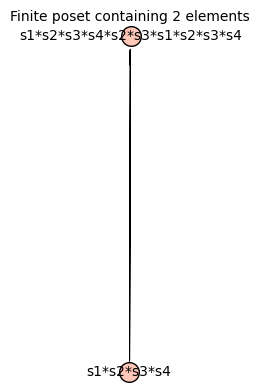

In [19]:
sc_JI(1,4)

In [ ]:
def is_socle_killing_chain(chain, wrong):
    '''Assuming chain is a list b1 < b2 < ... < bm, all from the same JI(i,j).
    wrong = complement_BG(i,j), but I want to calculate it in the outer function,
    so that it does not recalculate many times.'''
    
    for t in range(len(chain)-1):
        if is_socle_killing_pair(chain[t],chain[t+1], wrong) == False:
            return False
    return True
    
def order_chains(x,y):
    return (set(x)).issubset(set(y))

def max_socle_killing_chains(i,j):
    wrong = complement_BG(i,j)
    all_socle_killing_chains =  [tuple(chain) for chain in W_subposet(JI[(i,j)]).chains() if len(chain)>=2 and is_socle_killing_chain(chain, wrong)]

    return Poset((all_socle_killing_chains,order_chains)).maximal_elements()   



    
    
    